<a href="https://colab.research.google.com/github/Ace-Chrono/Coral_Lesion_Measurer/blob/main/Lesion_Measurer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Google Drive Linking

In [ ]:
from google.colab import drive, files

In [ ]:
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## PyTorch Setup

In [ ]:
import torch

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.__version__)
print(DEVICE) #Make sure to reload Anaconda if it prints out CPU even though it is the right PyTorch version

2.6.0+cu124
cuda:0


## YOLO Setup

In [ ]:
!pip install ultralytics #This is where we get the YOLO packages

In [ ]:
from ultralytics import YOLO

In [ ]:
lesion_bbox_model = YOLO("/content/gdrive/MyDrive/Colab Notebooks/Prototype Code/ML Models/YOLOV11_Lesion.pt")

In [ ]:
ruler_bbox_model = YOLO("/content/gdrive/MyDrive/Colab Notebooks/Prototype Code/ML Models/YOLOV11_Ruler.pt")

## SAM Setup

In [ ]:
!git clone https://github.com/facebookresearch/sam2.git sam2_repo
%cd sam2_repo
!pip install -e . --no-build-isolation

fatal: destination path 'sam2_repo' already exists and is not an empty directory.
/content/sam2_repo
Obtaining file:///content/sam2_repo
  Checking if build backend supports build_editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for SAM-2 (pyproject.toml) ... done
  Created wheel for SAM-2: filename=SAM_2-1.0-0.editable-cp311-cp311-linux_x86_64.whl size=13744 sha256=e0bcaeba26e3db35a8e85e4f2b2c0e9b8f45c82f02419525ea802d4e4f31944d
  Stored in directory: /tmp/pip-ephem-wheel-cache-98y8xp85/wheels/a3/2c/d5/dfadcadd6d3d572079cd6218a4b7ec6885fa349c5ba7335b4b
Successfully built SAM-2
  Attempting uninstall: SAM-2
    Found existing installation: SAM-2 1.0
    Uninstalling SAM-2-1.0:
      Successfully uninstalled SAM-2-1.0


In [ ]:
#If doesn't work after cloning sam2, restart anaconda and should fix any shadowing or other glitches
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

In [ ]:
sam_location = "/content/gdrive/MyDrive/Colab Notebooks/Prototype Code/ML Models/sam2.1_hiera_large.pt"
sam_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"
lesion_sam_model = SAM2ImagePredictor(build_sam2(sam_cfg, sam_location))

##GUI Setup

In [ ]:
!pip install --upgrade ipympl

##Libraries

In [ ]:
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import datetime
import json
import pandas as pd
from ipywidgets import Button, Output, VBox, HBox
from IPython.display import display, clear_output
import os
import gc

## YOLO and SAM Processing

In [ ]:
def open_image(image_path):
    image = Image.open(image_path)
    image_np = np.array(image)
    height, width, channels = image_np.shape
    return image, height, width

def image_info(image_name):
    date = None
    repetition = None
    id = None

    parentheses_match = re.search(r'\s*\((\d+)\)$', image_name)
    if parentheses_match:
       repetition = int(parentheses_match.group(1))
       image_name_clean = re.sub(r'\s*\(\d+\)$', '', image_name)
    else:
        image_name_clean = image_name

    date_match = re.search(r'(\d{4}_\d{2}_\d{2})', image_name_clean)
    if date_match:
        date_str = date_match.group(1)
        date = date_str.replace('_', '-')

    id_match = re.search(r'(LC[^_\s]*)', image_name_clean)
    if id_match:
        id = id_match.group(1)

    return id, date, repetition

def get_conversion_ratio(image, image_name):
    try:
        results = ruler_bbox_model.predict(image, verbose=False)
        if len(results) > 0 and len(results[0].boxes) > 0:
            bboxes = results[0].boxes
            if len(bboxes.xyxy) > 0:
                x_min, y_min, x_max, y_max = bboxes.xyxy[0].tolist()
                width = x_max - x_min
                height = y_max - y_min
                conversion_ratio = max(width, height) / 32
                print(f"Ruler detected in {image_name}: {conversion_ratio:.2f} pixels/mm")
                return conversion_ratio
    except Exception as e:
        print(f"Error in ruler detection for {image_name}: {str(e)}")

    return None

def run_yolo_lesion(image):
    results = lesion_bbox_model.predict(image, verbose=False)
    for result in results:
        bboxes = result.boxes
        bboxes = bboxes.xyxy.tolist()
    return bboxes

def run_sam(image, bboxes):
    bboxes_np = []
    for bbox in bboxes:
        bbox_np = np.array(bbox)
        bboxes_np.append(bbox_np)
    input_boxes = np.array(bboxes_np).astype(np.float32)
    with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
        lesion_sam_model.set_image(np.array(image))
        masks, _, _ = lesion_sam_model.predict(
            point_coords=None,
            point_labels=None,
            box=input_boxes,               # shape: (N, 4)
            multimask_output=False,
        )
    return masks

## Mask Manipulation

In [ ]:
def masks_to_polygons(masks):  # Creates polygons from a list of SAM masks
    all_polygons = []

    for mask in masks:
        mask = np.squeeze(mask)  # Ensures (H, W)

        if mask is None:
            raise ValueError(f"Mask {i} is None.")
        if mask.ndim != 2:
            raise ValueError(f"Mask {i} must be 2D after squeeze, got shape {mask.shape}")
        if mask.shape[0] == 0 or mask.shape[1] == 0:
            raise ValueError(f"Mask {i} has invalid shape {mask.shape}")
        if not np.any(mask):
            continue  # Skip empty masks

        # Convert mask to binary if it's not already
        if mask.max() > 1:
            _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        else:
            binary_mask = (mask * 255).astype(np.uint8)

        # Find contours
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        polygons = []
        for contour in contours:
            # Simplify the contour to reduce the number of points
            epsilon = 0.001 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # Extract points and flatten the list
            polygon = approx.reshape(-1, 2).tolist()
            flat_polygon = [point for sublist in polygon for point in sublist]
            polygons.append(flat_polygon)

        all_polygons.append(polygons)

    return all_polygons

def get_perimeter(all_polygons):
  perimeters = []
  for polygon in all_polygons:
    for points in polygon:
      contour = np.array(points).reshape(-1, 1, 2)
      perimeter = cv2.arcLength(contour, True)
      perimeter_cm = perimeter / conversion_ratio
      perimeter_um = perimeter_cm * 10_000
      perimeters.append(perimeter_um)

  return perimeters

def get_areas_and_centers(masks, bboxes, conversion_ratio):
    areas = []
    centers = []
    for mask in masks:
        area = np.count_nonzero(mask)
        area_um2 = area * ((1 / conversion_ratio)*10000)** 2
        areas.append(area_um2)
    for bbox in bboxes:
        x_min, y_min, x_max, y_max = bbox
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        centers.append((center_x, center_y))  # (x, y) format
    return areas, centers

## Annotation Manipulation

In [ ]:
def show_points(coords, labels, ax, marker_size=375): #Adds point prompts into the axes
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_bboxes(bboxes, ax): #Adds bounding boxes into the axes
    for bbox in bboxes:
        x0, y0 = bbox[0], bbox[1]
        w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        rect = plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)
        ax.add_patch(rect)

def show_masks(masks, ax, random_color=False): #Adds SAM masks into the axes
    for mask in masks:
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
        else:
            color = np.array([30/255, 144/255, 255/255, 0.2])  # semi-transparent blue

        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

def show_polygons(polygons_list, ax): #Adds a polygon made from the SAM mask into the axes
    for polygons in polygons_list:
        formatted_polygons = [np.array(polygon).reshape(-1, 2) for polygon in polygons]
        for polygon in formatted_polygons:
            polygon_patch = patches.Polygon(polygon, closed=True, edgecolor='red', facecolor=(0, 0, 0, 0), lw=2)
            ax.add_patch(polygon_patch)

def show_areas(areas, centers, ax): #Adds the ground truth areas to the axes
    for i, (area, center) in enumerate(zip(areas, centers)):
        x, y = center
        ax.text(x, y, str(area) + " um^2", color='white', fontsize=16, backgroundcolor='black')

## Outputting

In [ ]:
def output_image(image, height, width, image_output_path, bboxes, masks, segmentations, area, centers):
    scale_factor = 100
    fig, ax = plt.subplots(figsize=(width / scale_factor, height / scale_factor))
    ax.set_position([0, 0, 1, 1])
    ax.set_axis_off()
    ax.imshow(image, aspect='auto')
    show_bboxes(bboxes, ax)
    show_masks(masks, ax)
    show_polygons(segmentations, ax)
    show_areas(areas, centers, ax)
    fig.savefig(os.path.join(image_output_path), dpi=100)
    plt.close(fig)

def output_csv(folder_name, image_name, lesion_count, conversion_ratio, areas, perimeters, csv_output_path):
    new_row = {
        "Folder": folder_name,
        "Image Name": image_name,
        "# Lesions": lesion_count,
        "Pixels Per um": conversion_ratio,
        "um^2": areas,
        "Perimeters": perimeters
        }
    new_row_df = pd.DataFrame([new_row], columns=csv_columns)
    new_row_df.to_csv(csv_output_path, mode='a', header=not os.path.exists(csv_output_path), index=False)

def get_metadata(index, image_name, height, width, bboxes, segmentations):
    image_info = {
        "id": index,
        "license": 1,
        "file_name": image_name,
        "height": height,
        "width": width,
        "date_captured": datetime.datetime.now().isoformat()
    }
    annotations = []
    for annotation_id, (bbox, segmentation) in enumerate(zip(bboxes, segmentations)):
        x_min, y_min, x_max, y_max = bbox
        width_box = x_max - x_min
        height_box = y_max - y_min
        area = width_box * height_box

        annotation_info = {
            "id": index * 1000 + annotation_id,  # ensures uniqueness
            "image_id": index,
            "category_id": 1,
            "bbox": [x_min, y_min, width_box, height_box],
            "area": area,
            "segmentation": segmentation,
            "iscrowd": 0
        }
        annotations.append(annotation_info)
    return image_info, annotations

def output_coco_json(image_info_list, annotations_list, output_path):
    coco_dict = {
        "info": {
            "description": "Coral Dataset",
            "version": "1.0",
            "year": 2025,
            "contributor": "Richard Zhao",
            "date_created": datetime.datetime.now().isoformat()
        },
        "licenses": [
            {
                "id": 1,
                "name": "Attribution-NonCommercial-ShareAlike License",
                "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/"
            }
        ],
        "images": image_info_list,
        "annotations": annotations_list,
        "categories": [
            {
                "id": 1,
                "name": "coral lesion",
                "supercategory": "marine_life"
            }
        ]
    }

    # Save to JSON file
    with open(output_path, "w") as f:
        json.dump(coco_dict, f, indent=4)


def append_row_to_excel(file_path, new_row_dict):
    if os.path.exists(file_path):
        df_existing = pd.read_excel(file_path)
        # Check if date already exists
        if new_row_dict['Date'] in df_existing['Date'].values:
            print(f"Skipping duplicate date {new_row_dict['Date']} in {file_path}")
            return
        df_existing = pd.concat([df_existing, pd.DataFrame([new_row_dict])], ignore_index=True)
        df_existing = df_existing.sort_values(by='Date')
        df_existing.to_excel(file_path, index=False)
    else:
        pd.DataFrame([new_row_dict]).to_excel(file_path, index=False)

##Manual Conversion Ratio GUI

In [ ]:
class ClickCollector:
    def __init__(self, image, image_name="Image", on_done=None):
        self.image = image
        self.image_name = image_name
        self.on_done = on_done
        self.coords = []
        self.line = None
        self.dots = []
        self.click_mode = False

        self.out = Output()

        # Setup plot
        with self.out:
            self.fig, self.ax = plt.subplots(figsize=(8,6))
            self.ax.imshow(self.image)
            self.ax.set_title(f"{self.image_name}")
            self.cid = self.fig.canvas.mpl_connect('button_press_event', self.onclick)
            plt.show()

        # Buttons
        self.click_button = Button(description="Enable Click Mode", button_style='primary')
        self.click_button.on_click(self.toggle_click_mode)

        self.clear_button = Button(description="Clear", button_style='danger')
        self.clear_button.on_click(self.clear)

        self.finish_button = Button(description="Finish", button_style='success')
        self.finish_button.on_click(self.finish)

        # Distance input & submit button, hidden initially
        self.dist_input = widgets.FloatText(description="Real distance (cm):")
        self.dist_submit = widgets.Button(description="Submit distance")
        self.dist_submit.on_click(self.submit_distance)
        self.dist_input.layout.display = 'none'
        self.dist_submit.layout.display = 'none'

        display(VBox([
            self.out,
            HBox([self.click_button, self.clear_button, self.finish_button]),
            VBox([self.dist_input, self.dist_submit])
        ]))

    def toggle_click_mode(self, b):
        self.click_mode = not self.click_mode
        if self.click_mode:
            self.click_button.description = "Click Mode: ON (Click Image)"
            self.click_button.button_style = 'warning'
            print("🖱️ Click mode enabled: Click two points.")
        else:
            self.click_button.description = "Click Mode: OFF"
            self.click_button.button_style = 'primary'
            print("✋ Click mode disabled: Use zoom/pan tools.")

    def onclick(self, event):
        if not self.click_mode or event.inaxes != self.ax:
            return
        x, y = event.xdata, event.ydata
        print(f"📍 Clicked at ({x:.1f}, {y:.1f})")
        self.coords.append((x, y))
        self.draw_dot(x, y)
        if len(self.coords) == 2:
            self.draw_line()
            self.toggle_click_mode(None)

    def draw_dot(self, x, y):
        dot = self.ax.plot(x, y, 'ro', markersize=6)[0]
        self.dots.append(dot)
        self.fig.canvas.draw()

    def draw_line(self):
        x_vals = [self.coords[0][0], self.coords[1][0]]
        y_vals = [self.coords[0][1], self.coords[1][1]]
        if self.line:
            self.line.remove()
        self.line, = self.ax.plot(x_vals, y_vals, 'r-', linewidth=2)
        self.fig.canvas.draw()

    def clear(self, b):
        # Clear all dots
        for dot in self.dots:
            dot.remove()
        self.dots = []

        # Clear line
        if self.line:
            self.line.remove()
            self.line = None

        self.coords = []
        self.fig.canvas.draw()
        print("🧹 Cleared all points and lines.")

    def finish(self, b):
        if len(self.coords) != 2:
            with self.out:
                print("Please click exactly 2 points before finishing.")
            return
        with self.out:
            print(f"✅ Line set from {self.coords[0]} to {self.coords[1]}")
            print("Please enter the real-world distance (cm) below:")
        # Show distance input widgets
        self.dist_input.layout.display = None
        self.dist_submit.layout.display = None

    def submit_distance(self, b):
        dist = self.dist_input.value
        if dist <= 0:
            with self.out:
                print("Distance must be positive.")
            return
        pixel_dist = np.linalg.norm(np.array(self.coords[0]) - np.array(self.coords[1]))
        ratio = pixel_dist / dist
        with self.out:
            print(f"➡️ Pixel distance: {pixel_dist:.2f}")
            print(f"➡️ Real distance: {dist:.2f} cm")
            print(f"➡️ Conversion ratio: {ratio:.2f} pixels/cm")
        if self.on_done:
            self.on_done(ratio)

## Define Path Information

In [ ]:
image_input_root = "/content/gdrive/MyDrive/Colab Notebooks/Prototype Code/Input/"

image_input_path = [
    os.path.join(root, d)
    for root, dirs, _ in os.walk(image_input_root)
    for d in dirs
]
image_input_path.append(image_input_root)

image_output_path = "/content/gdrive/MyDrive/Colab Notebooks/Prototype Code/Output/"
csv_output_path = image_output_path + "/coral_areas_output.csv"
csv_columns = ["Folder", "Image Name", "# Lesions", "Pixels Per um", "um^2", "Perimeters"]

areas_folder = os.path.join(image_output_path, "areas")
perimeters_folder = os.path.join(image_output_path, "perimeters")
os.makedirs(areas_folder, exist_ok=True)
os.makedirs(perimeters_folder, exist_ok=True)

## Run Measurer

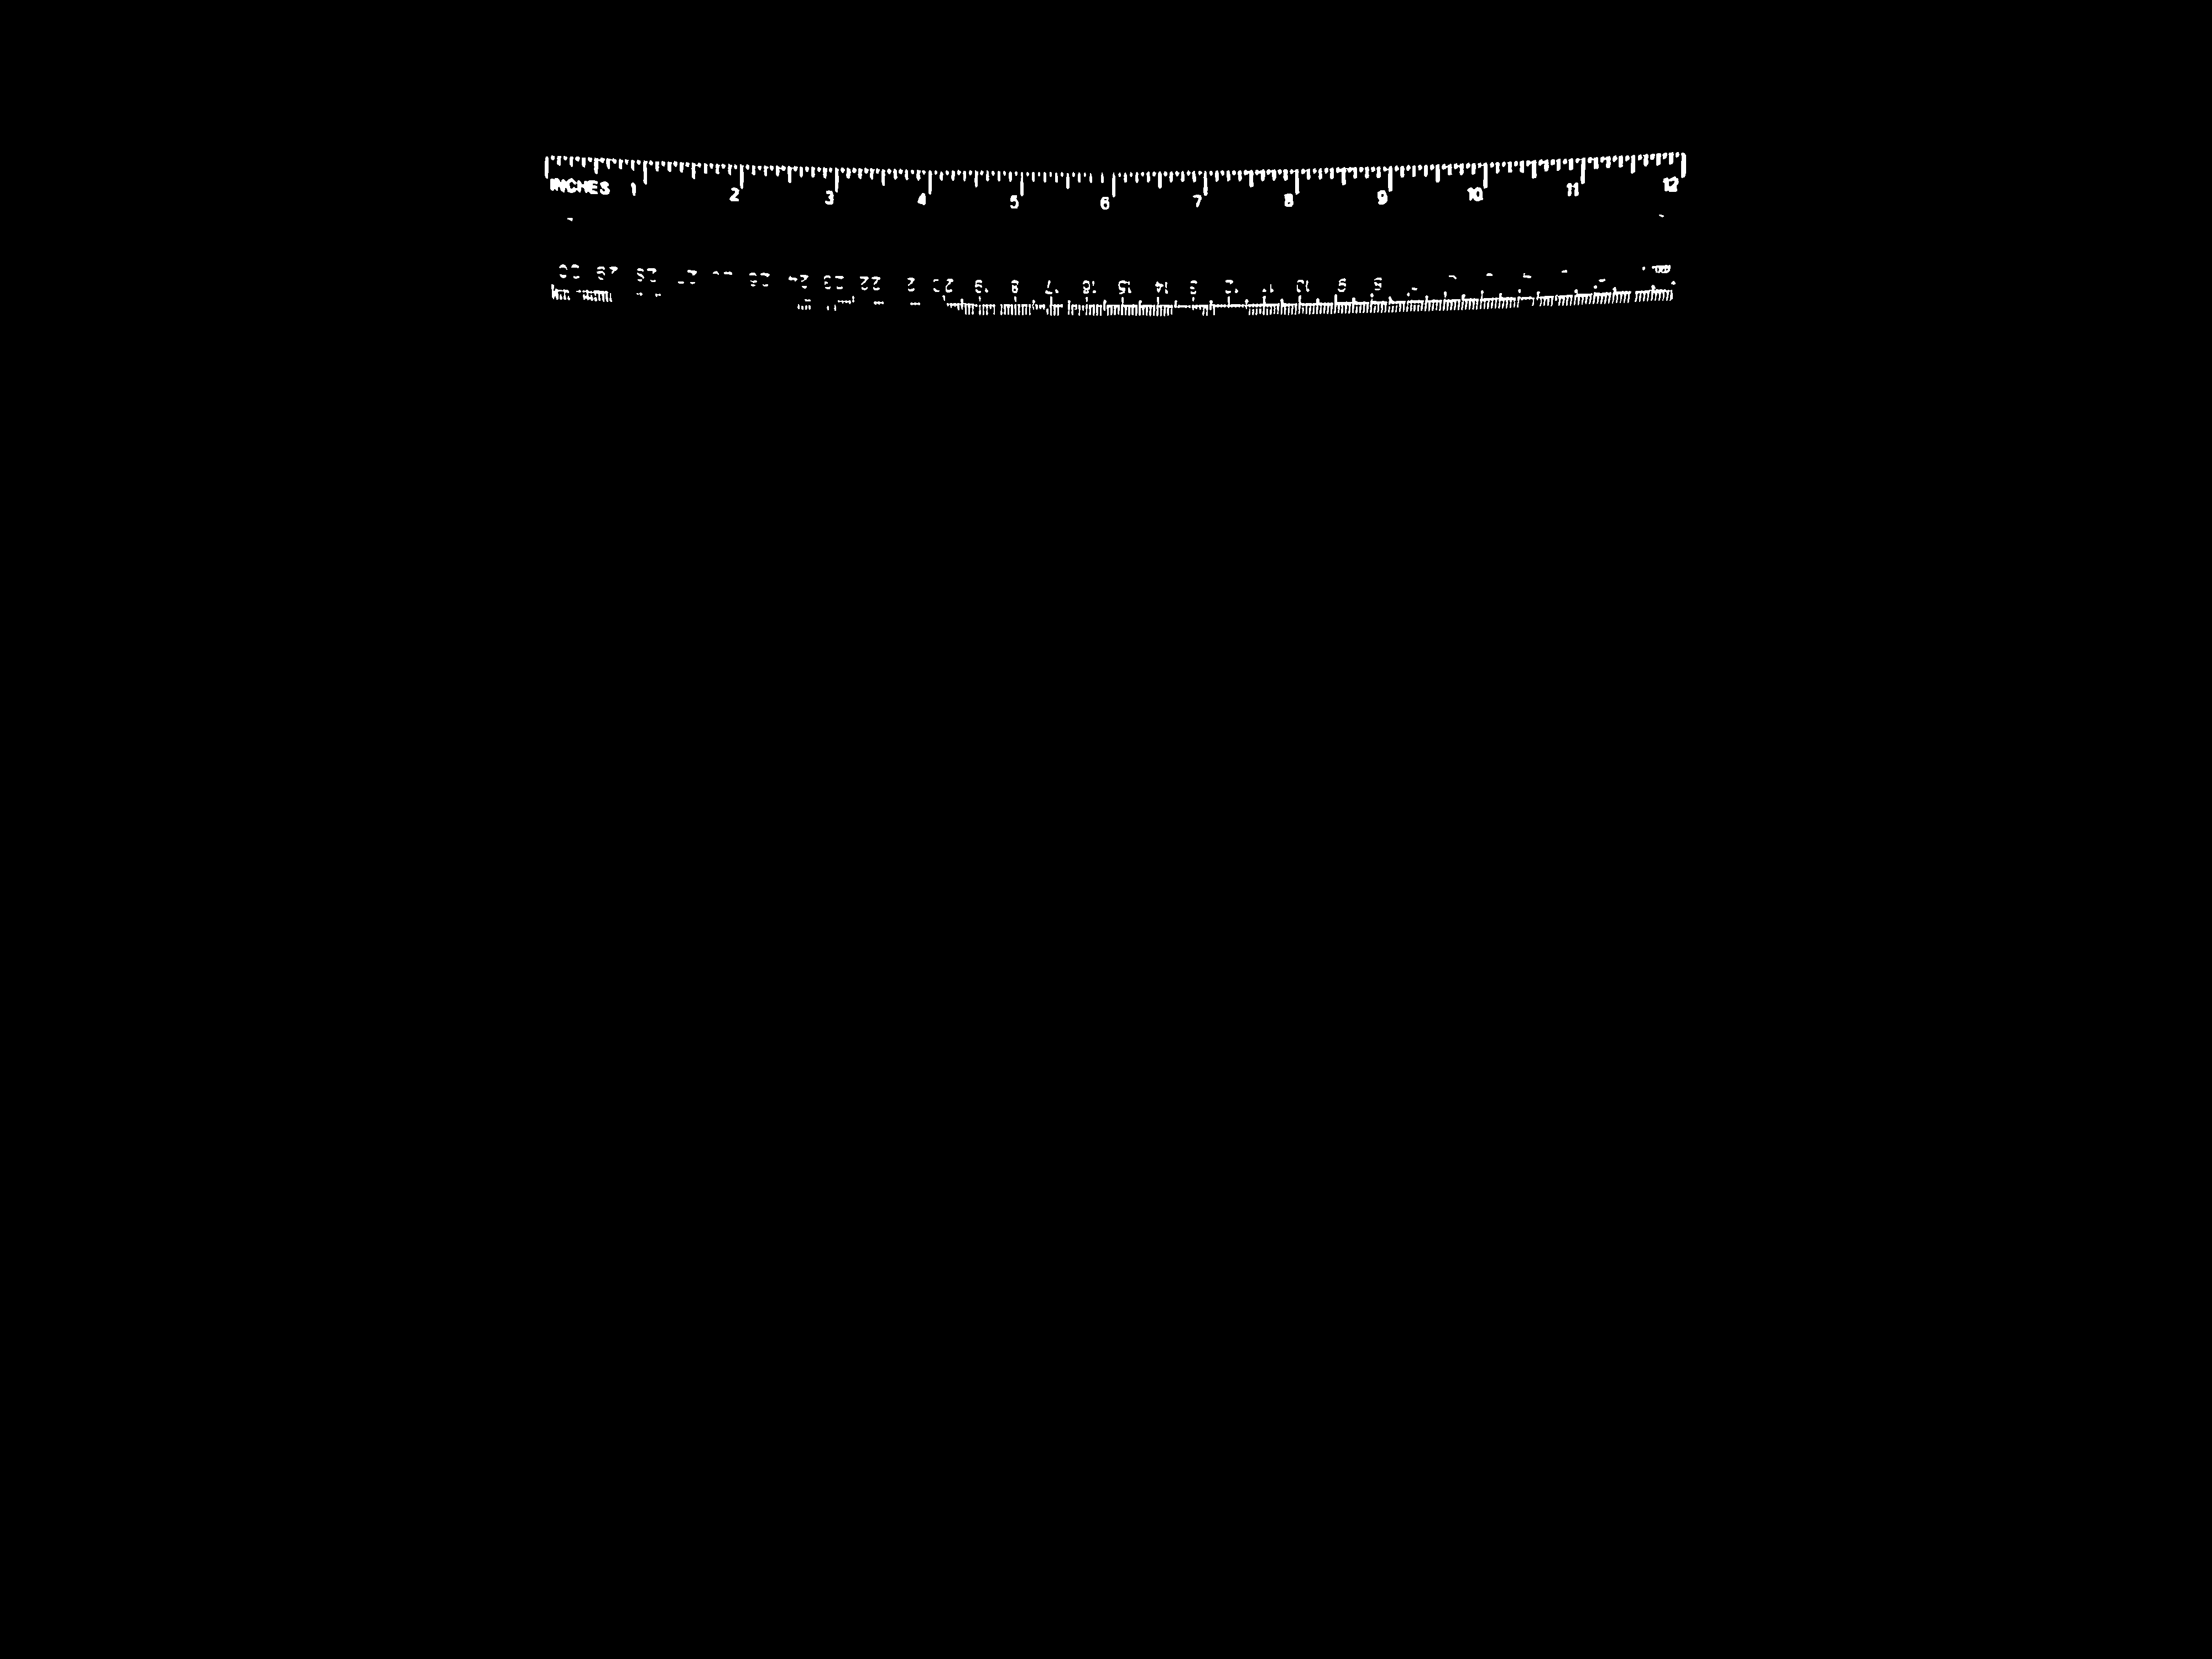

76.58059999999999
[(985, 283, 7, 40), (995, 322, 86, 29), (996, 281, 7, 9), (1007, 282, 8, 18), (1019, 282, 7, 8), (1026, 394, 10, 6), (1030, 283, 7, 19), (1040, 283, 9, 9), (1052, 285, 7, 18), (1063, 284, 8, 9), (1074, 285, 20, 30), (1085, 328, 18, 24), (1096, 286, 19, 20), (1119, 287, 8, 19), (1130, 288, 7, 10), (1141, 330, 9, 24), (1141, 289, 7, 20), (1151, 289, 8, 9), (1163, 290, 8, 44), (1173, 290, 8, 9), (1185, 292, 7, 18), (1196, 291, 7, 10), (1207, 292, 8, 19), (1217, 291, 8, 11), (1229, 293, 8, 19), (1239, 293, 8, 9), (1250, 294, 18, 30), (1273, 295, 7, 19), (1283, 295, 7, 10), (1294, 296, 8, 19), (1304, 296, 8, 9), (1316, 296, 8, 21), (1319, 339, 18, 25), (1327, 297, 6, 9), (1338, 297, 7, 45), (1348, 297, 7, 10), (1359, 299, 7, 18), (1370, 300, 7, 8), (1381, 299, 9, 20), (1392, 299, 7, 10), (1403, 299, 18, 20), (1424, 300, 19, 31), (1446, 301, 6, 20), (1456, 301, 7, 10), (1467, 301, 7, 20), (1478, 302, 7, 9), (1488, 302, 8, 21), (1492, 344, 16, 26), (1499, 303, 6, 9), (1510, 

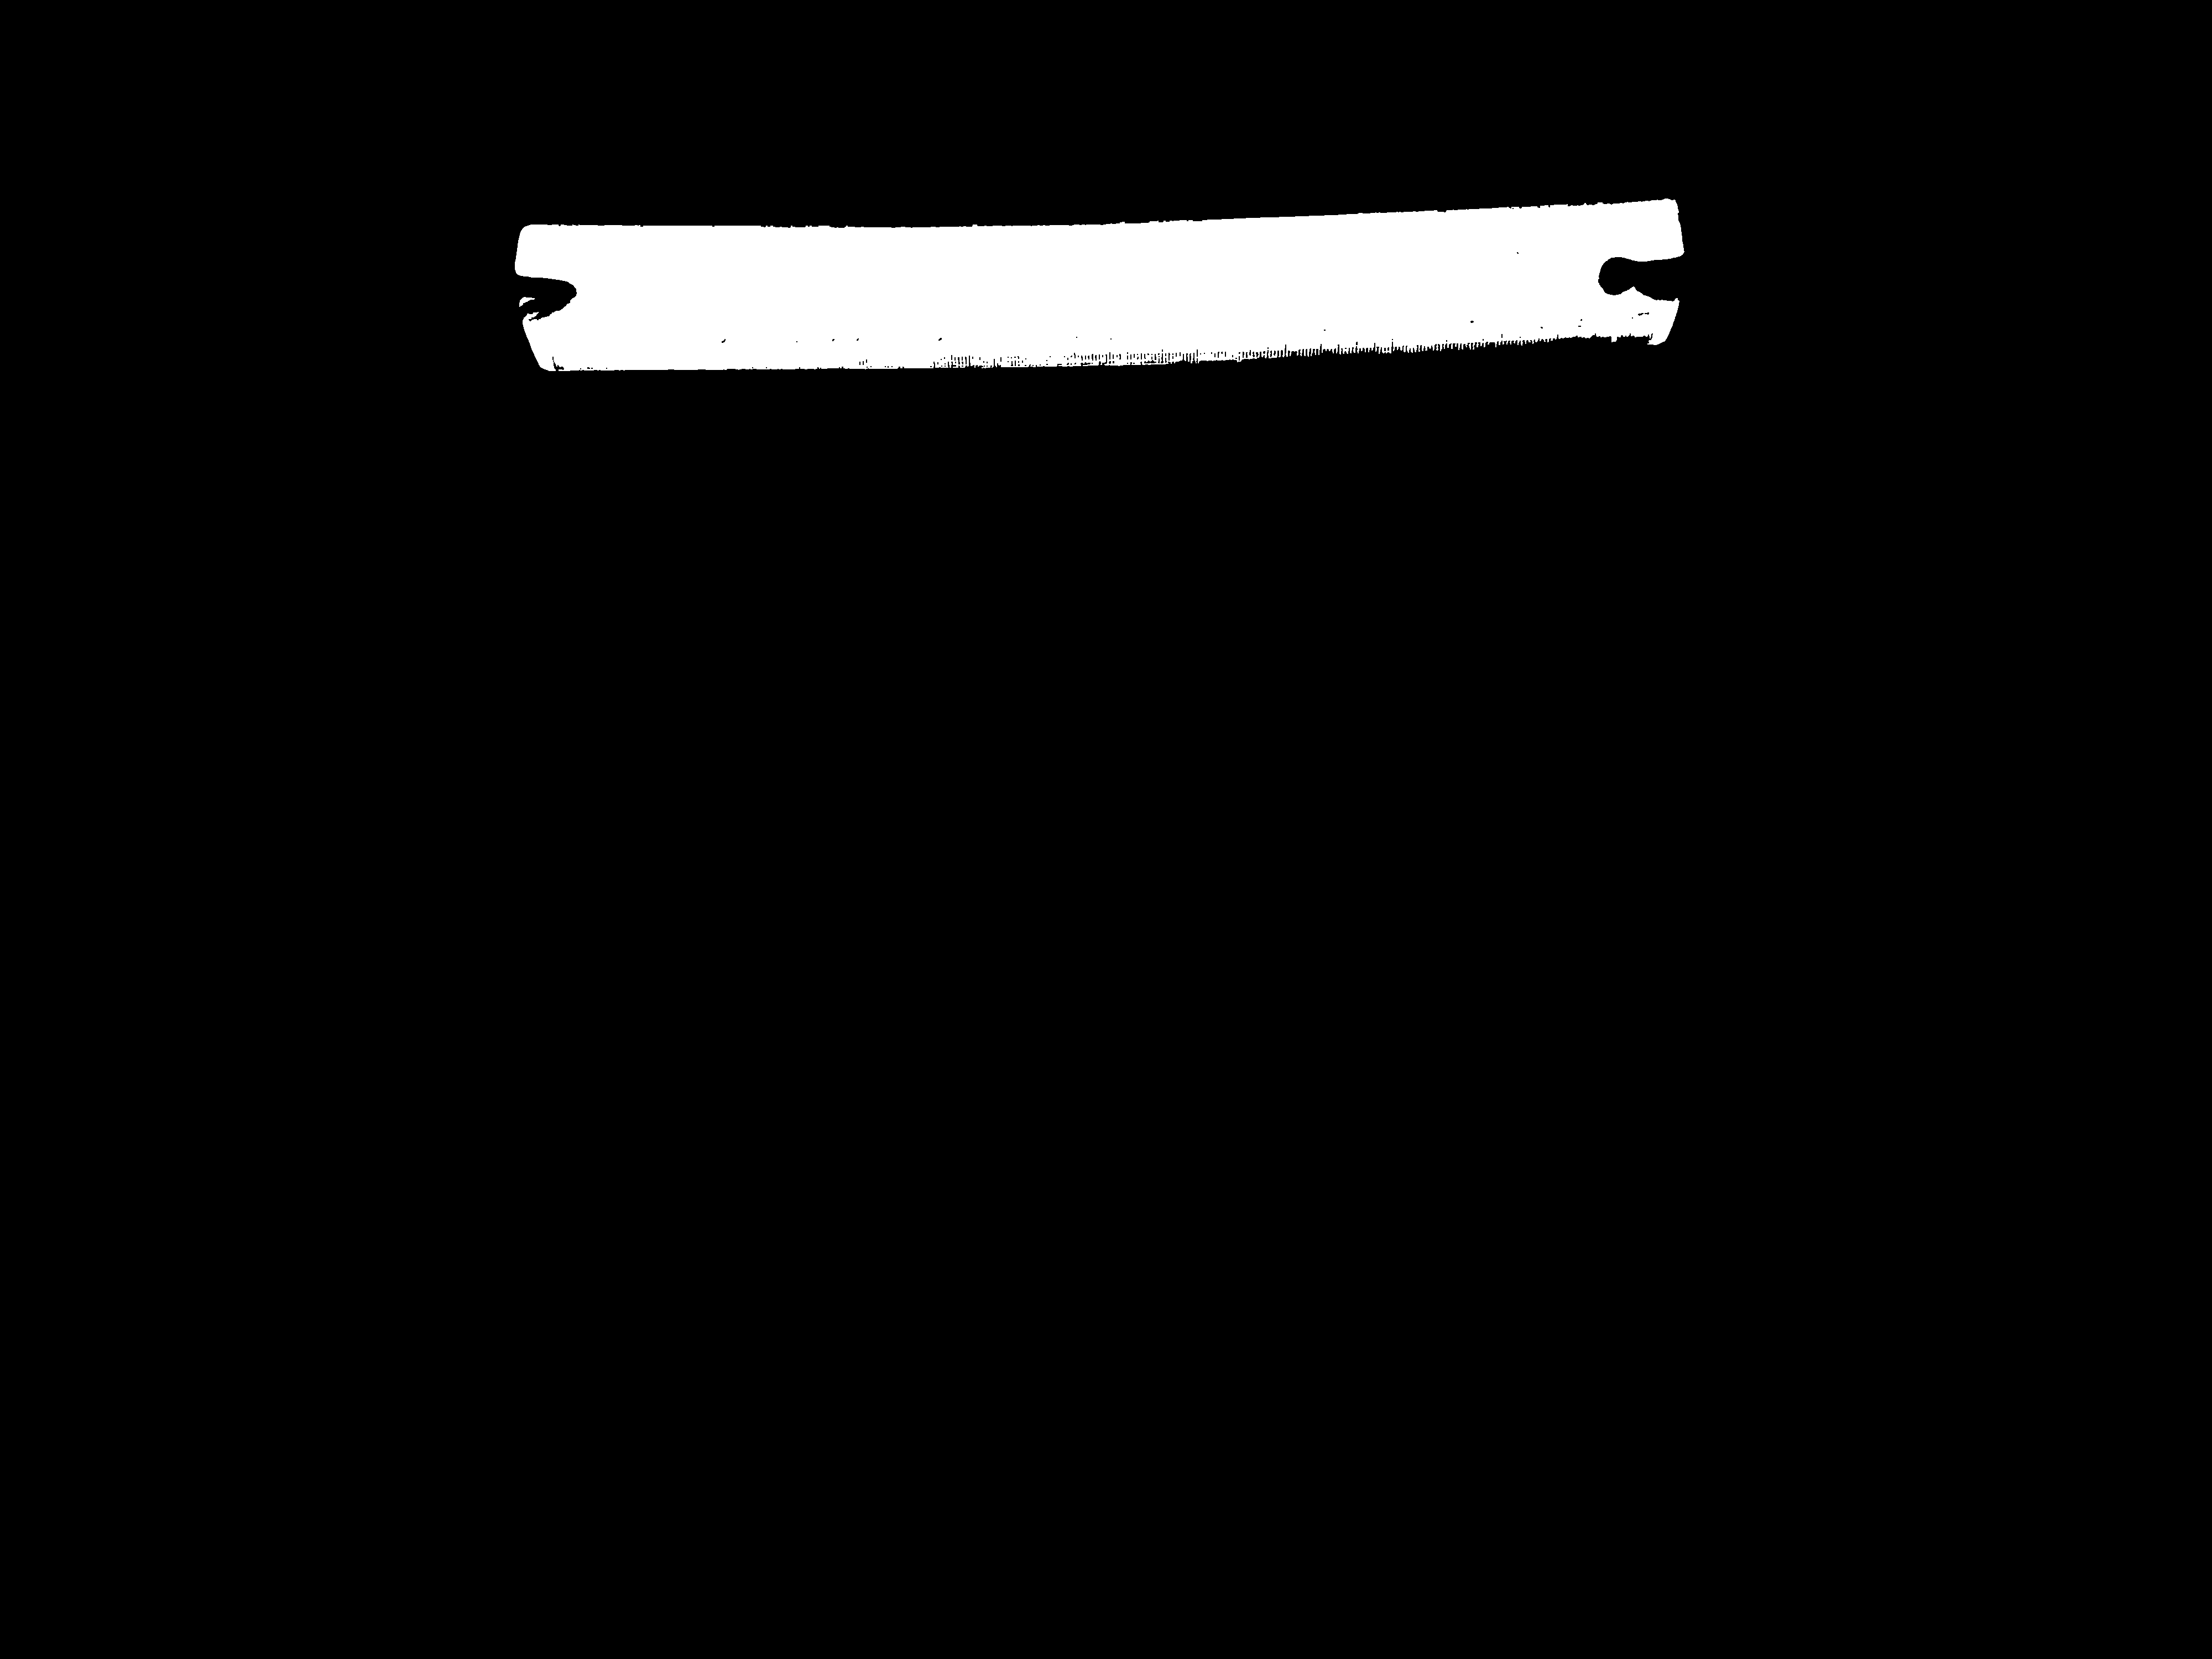

244.1846
[(0, 0, 4000, 462), (2735, 376, 2, 2), (2743, 456, 3, 3)]
Ruler detected in RRC_S1_ECA_LC-056_a_2021_05_28 (1): 66.69 pixels/mm


In [ ]:
pending_conversion = {}

for index, folder in enumerate(image_input_path):
    image_metadata_list = []
    annotation_metadata_list = []
    folder_name = os.path.basename(folder.rstrip('/'))
    json_output_path = os.path.join(image_output_path, "_annotations.coco.json")
    image_index = 0

    for file in os.listdir(folder):
        if file.endswith('.JPG'):
            old_image_path = os.path.join(folder, file)
            image_name, _ = os.path.splitext(file)
            image_name_png = image_name + ".png"
            new_image_path = os.path.join(image_output_path, image_name_png)
            image, height, width = open_image(old_image_path)

            conversion_ratio = get_conversion_ratio(image, image_name)
            if conversion_ratio is None:
                pending_conversion[image_name] = (image, height, width, old_image_path)
                continue

            bboxes_lesion = run_yolo_lesion(image)
            masks_lesion = run_sam(image, bboxes_lesion)
            segmentations = masks_to_polygons(masks_lesion)
            perimeters = get_perimeter(segmentations)
            areas, centers = get_areas_and_centers(masks_lesion, bboxes_lesion, conversion_ratio)
            id, date, repetition = image_info(image_name)

            area_file = os.path.join(areas_folder, f"{id}_areas.xlsx")
            perim_file = os.path.join(perimeters_folder, f"{id}_perimeters.xlsx")
            area_row = {'Date': date}
            for i, a in enumerate(areas):
                area_row[f'Area {i+1}'] = a
            perim_row = {'Date': date}
            for i, p in enumerate(perimeters):
                perim_row[f'Perimeter {i+1}'] = p
            append_row_to_excel(area_file, area_row)
            append_row_to_excel(perim_file, perim_row)

            output_image(image, height, width, new_image_path, bboxes_lesion, masks_lesion, segmentations, areas, centers)
            output_csv(folder_name, image_name_png, len(masks_lesion), conversion_ratio, areas, perimeters, csv_output_path)

            image_metadata, annotation_metadata = get_metadata(image_index, image_name_png, height, width, bboxes_lesion, segmentations)
            image_metadata_list.append(image_metadata)
            annotation_metadata_list.append(annotation_metadata)

            image_index += 1
            gc.collect()
            torch.cuda.empty_cache()

    output_coco_json(image_metadata_list, annotation_metadata_list, json_output_path)

if pending_conversion:
    def handle_ratio(ratio):
        print(f"Received ratio: {ratio:.2f} pixels/cm")

    image_name = list(pending_conversion.keys())[0]
    image, height, width, old_image_path = pending_conversion[image_name]

    collector = ClickCollector(image, image_name, on_done=handle_ratio)